In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import csv

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
tf.random.set_seed(1)

In [2]:
data_dir = "dataset/dataset/" 

In [3]:
print(os.listdir(data_dir))

['artists.csv', 'images', 'resized']


In [4]:
artists = pd.read_csv(data_dir + '/artists.csv')

artists.shape

(50, 8)

In [5]:
artist_names = ['Andy Warhol', 'Claude Monet', 'Edvard Munch', 'Henri Matisse', 'Leonardo da Vinci', 'Michelangelo', 'Pablo Picasso', 'Rembrandt', 'Salvador Dali', 'Vincent van Gogh']


# Create a boolean mask to select rows that match the artist names
mask = artists['name'].isin(artist_names)

# Rearrange the DataFrame so that rows matching the artist names are at the top
artists = pd.concat([artists[mask], artists[~mask]])

# Now, you have rearranged the artists DataFrame, and you can create artists_choosen
artists_choosen = artists[mask].copy()

# Reset the index of artists_choosen if needed
artists_choosen.reset_index(drop=True, inplace=True)

id_mapping = {
    3: 1,
    5: 2,
    8: 3,
    13: 4,
    26: 5,
    28: 6,
    31: 7,
    37: 8,
    45: 9,
    48: 10
}

# Use the map function to replace the 'id' values

artists_choosen = artists_choosen.rename(columns={'Unnamed: 0': 'id'})
artists_choosen['id'] = artists_choosen['id'].map(id_mapping)


print(artists_choosen.shape)


c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


(10, 8)


In [6]:
artists_choosen['class_weight'] = artists_choosen.paintings.sum() / (artists_choosen.shape[0] *artists_choosen.paintings)
artists_choosen = artists_choosen[['name' , 'paintings', 'class_weight']]
artists_choosen

,name,paintings,class_weight
0,Claude Monet,73,3.309589
1,Salvador Dali,139,1.738129
2,Vincent van Gogh,877,0.275485
3,Pablo Picasso,439,0.550342
4,Leonardo da Vinci,143,1.689510
5,Henri Matisse,186,1.298925
6,Rembrandt,262,0.922137
7,Edvard Munch,67,3.605970
8,Andy Warhol,181,1.334807
9,Michelangelo,49,4.930612


In [7]:
class_weights = artists_choosen['class_weight'].to_dict()
class_weights

{0: 3.3095890410958906,
 1: 1.7381294964028777,
 2: 0.275484606613455,
 3: 0.5503416856492027,
 4: 1.6895104895104895,
 5: 1.2989247311827956,
 6: 0.9221374045801527,
 7: 3.6059701492537313,
 8: 1.3348066298342542,
 9: 4.930612244897959}

In [8]:
images_dir = data_dir + 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_choosen['name'].str.replace(' ', '_').values
found = 0 
not_found = 0 
# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
        found +=1
    else:
        print("Did not find -->", os.path.join(images_dir, name))
        not_found +=1
print("\nClass found: " + str(found) + "\nClass not found: " +  str(not_found) )

Found --> dataset/dataset/images/images\Claude_Monet
Found --> dataset/dataset/images/images\Salvador_Dali
Found --> dataset/dataset/images/images\Vincent_van_Gogh
Found --> dataset/dataset/images/images\Pablo_Picasso
Found --> dataset/dataset/images/images\Leonardo_da_Vinci
Found --> dataset/dataset/images/images\Henri_Matisse
Found --> dataset/dataset/images/images\Rembrandt
Found --> dataset/dataset/images/images\Edvard_Munch
Found --> dataset/dataset/images/images\Andy_Warhol
Found --> dataset/dataset/images/images\Michelangelo

Class found: 10
Class not found: 0


In [9]:
batch_size = 4
train_input_shape = (224, 224, 3)
n_classes = artists_choosen.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 1938 images belonging to 10 classes.
Found 478 images belonging to 10 classes.


Total number of batches = 484 and 119


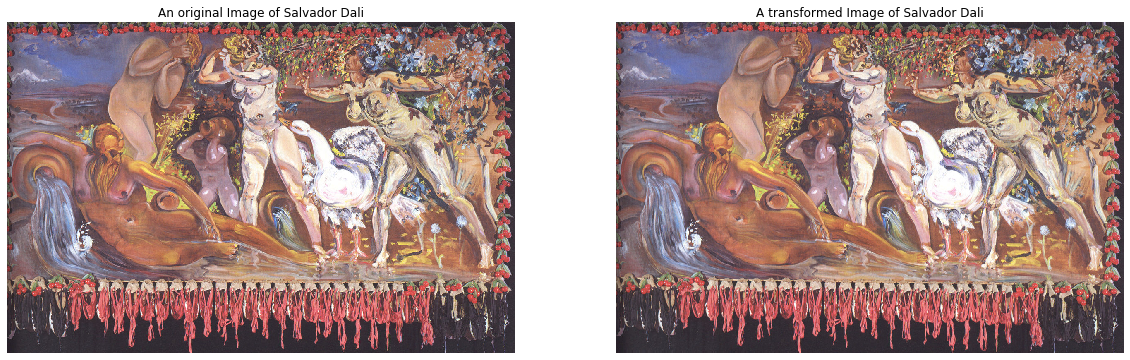

In [10]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices available.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [12]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [13]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [15]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [16]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [17]:
history1 = model.fit(
    x=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=n_epoch,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr],
    use_multiprocessing=True,
    workers=16,
    class_weight=class_weights
)

Epoch 1/10


Exception in thread Thread-37:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "c:\ProgramData\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\someo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\data_utils.py", line 860, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "C:\Users\someo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\data_utils.py", line 839, in pool_fn
    initargs=(seqs, None, get_worker_id_queue()))
  File "c:\ProgramData\Anaconda3\lib\multiprocessing\context.py", line 119, in Pool
    context=self.get_context())
  File "c:\ProgramData\Anaconda3\lib\multiprocessing\pool.py", line 176, in __init__
    self._repopulate_pool()
  File "c:\ProgramData\Anaconda3\lib\multiprocessing\pool.py", line 241, in _repopulate_pool
    w.start()
